# Note for Maya\Yair\Eran:
This notebook is for the final submission, and will contain the entire project flow.
In order to update this document please submit a Purll Request from your branch to the master branch, with the other team mates as reviewers.

Until then, please develop in a separate notebook, with the name '{your_name}_in_progress.ipynb'.
Updates to '...in_progress' notebook should not be pushed to master.

# House Prices - Regression Predictions YData 2024
Team: TODO

Team mates: Eran T, Maya L, Yair BH, Adir Golan.

TODO: add table of content with links

## Part 1 - EDA

In [41]:
from utils import load_house_prices_data
import matplotlib.pyplot as plt 

train_origin_df = load_house_prices_data('train')
train_features = train_origin_df.drop('SalePrice', axis='columns')

### 1.1 Which 3 features have the highest number of missing values?

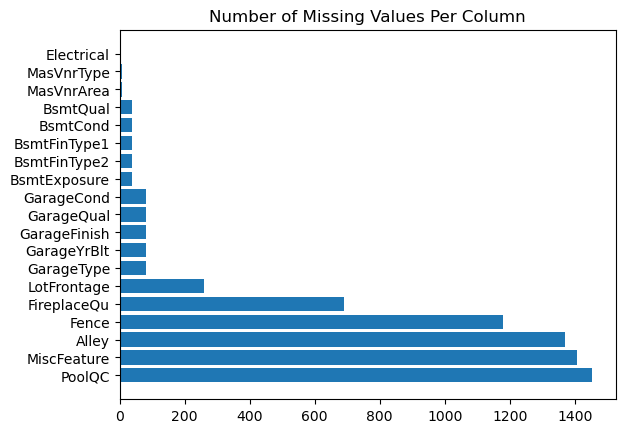

Top 3 features with the most missing values: ['PoolQC' 'MiscFeature' 'Alley']


In [2]:
from utils import calc_num_missing_vals_per_col, np

num_of_nans = calc_num_missing_vals_per_col(train_features)

fig, ax = plt.subplots()
y_pos = np.arange(len(num_of_nans))
ax.barh(y_pos, num_of_nans.values, align='center')
ax.set_yticks(y_pos, labels=num_of_nans.index)
ax.set_title('Number of Missing Values Per Column')
plt.show()

max_nans = num_of_nans.nlargest(3).index
print(f"Top 3 features with the most missing values: {max_nans.values}")

### 1.2 How does the price behave over the years?

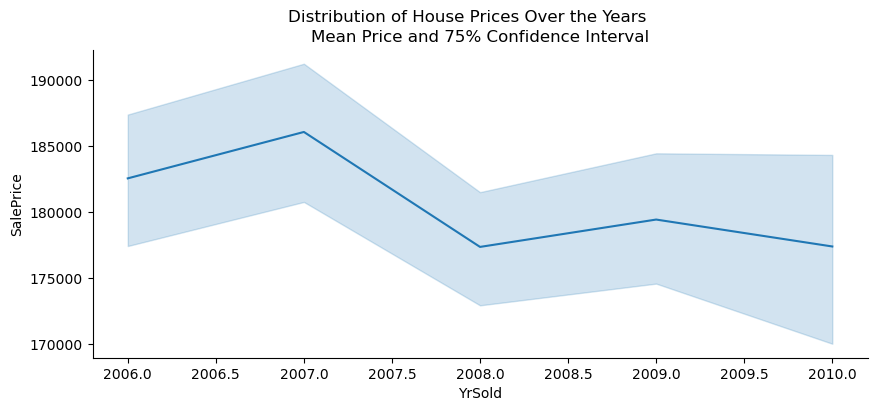

In [3]:
from utils import plot_price_dist_per_year

plot_price_dist_per_year(train_origin_df)

Graph Insight:
Over the 4 years shown, the mean price have fluctuated; increasing until 2007, with a down movement overall.

### 1.3 Plotting feature distribution using histograms

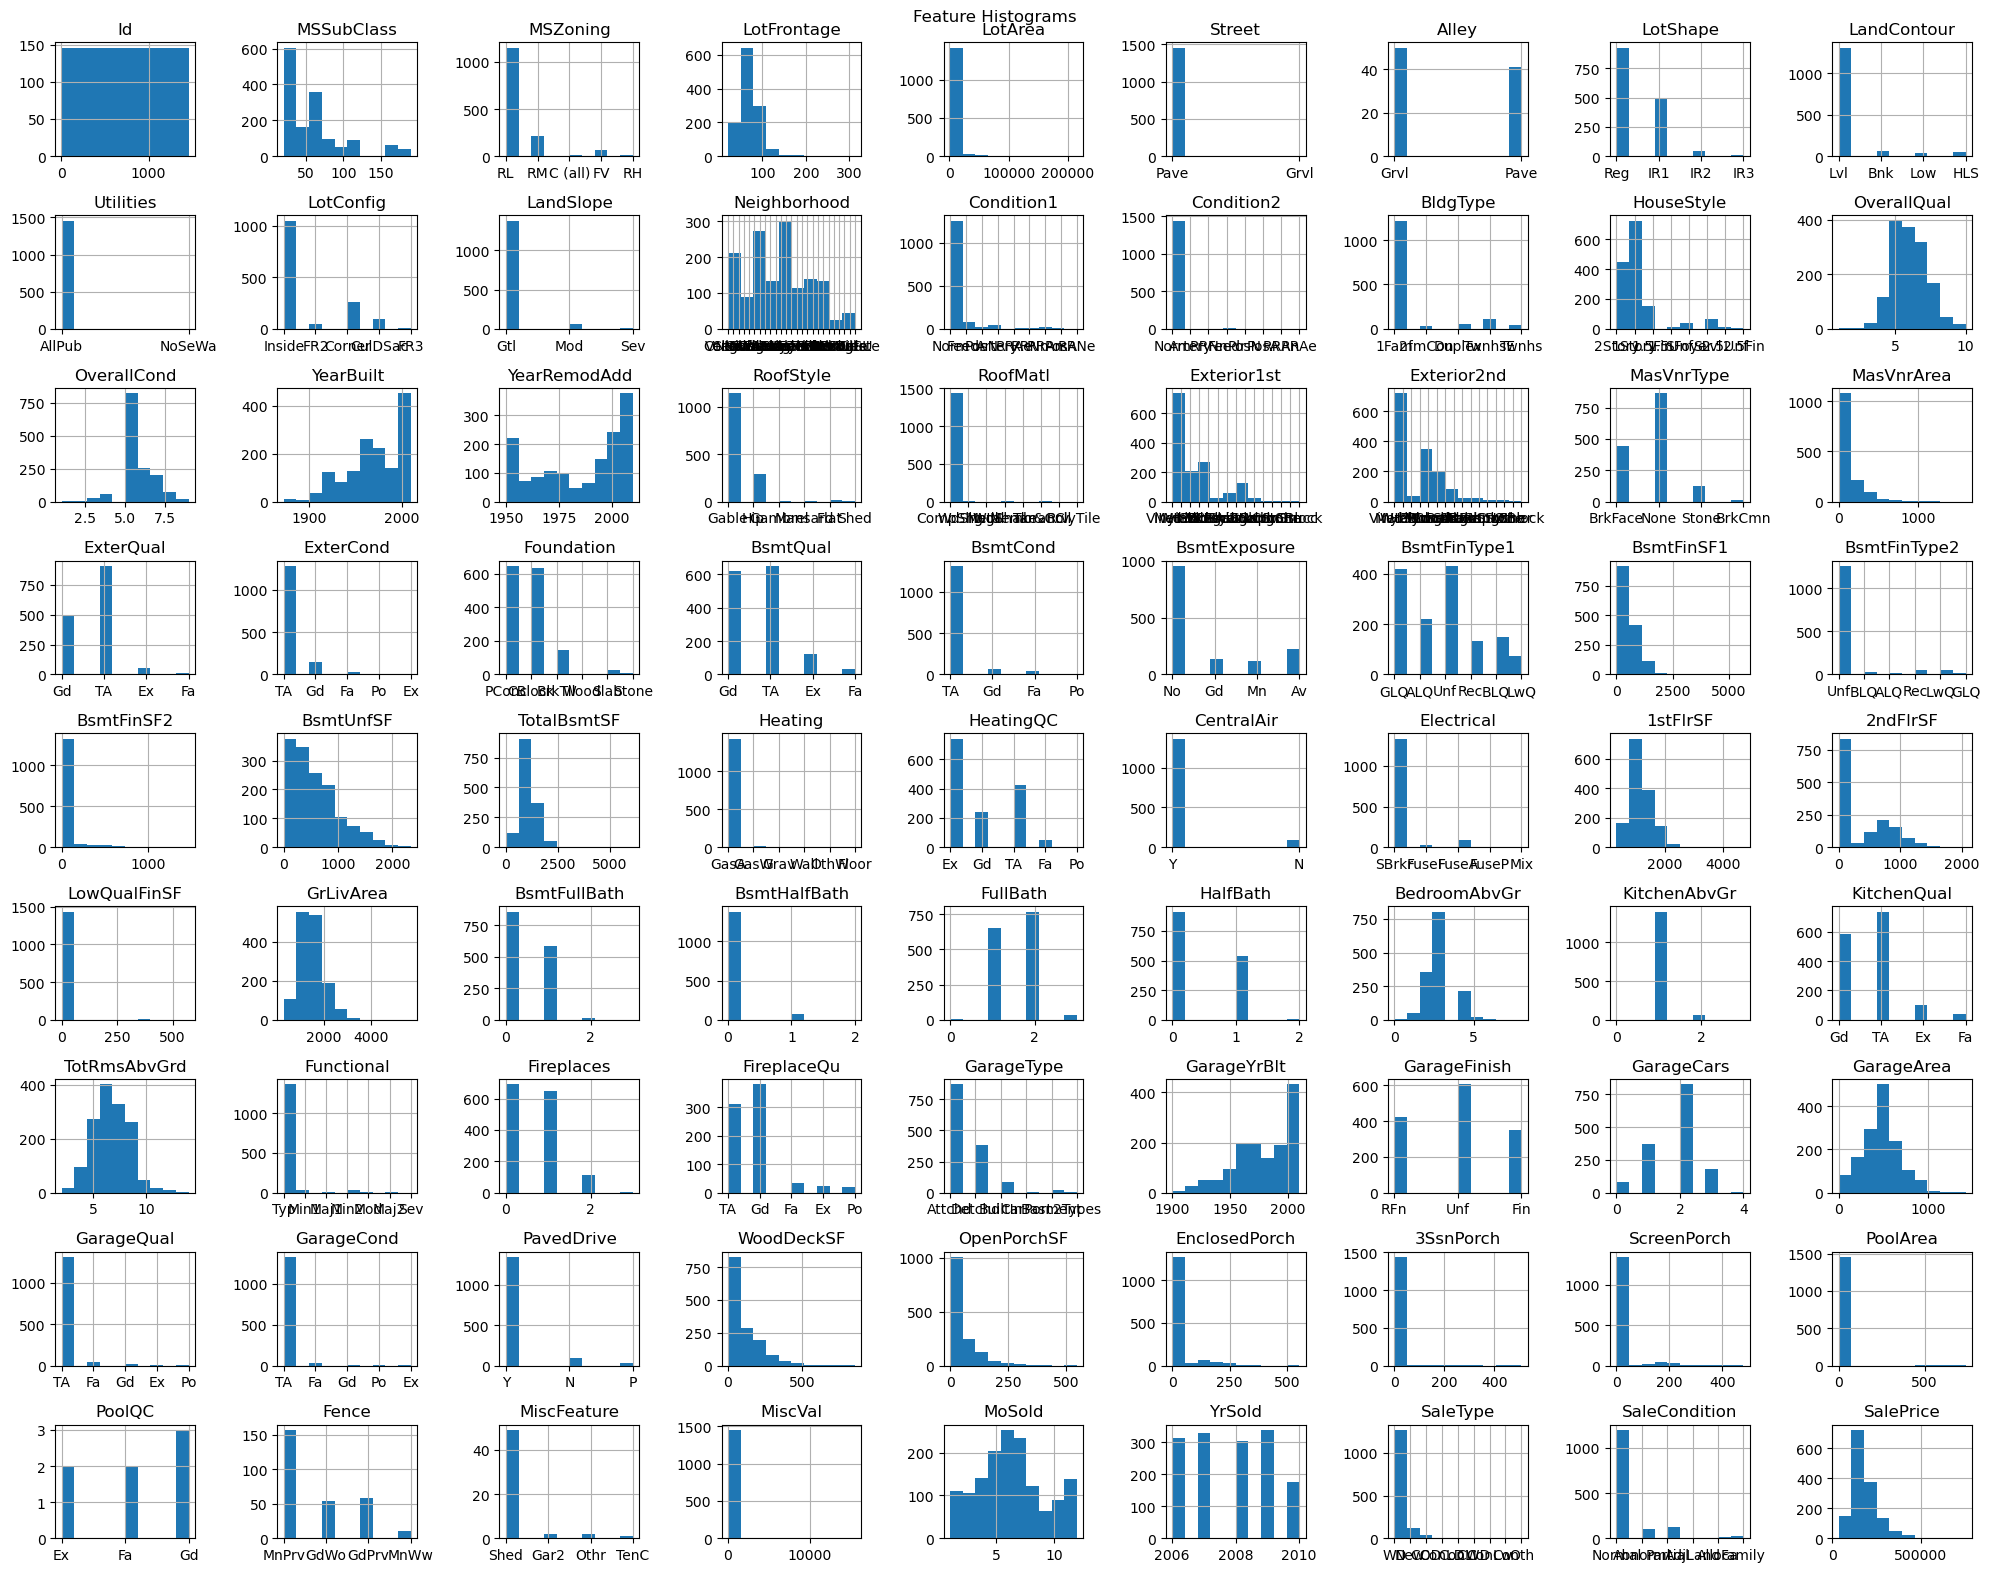

In [4]:
fig, axes = plt.subplots(ncols=9, nrows=9, figsize=(20,16))
for col_index, col in enumerate(train_origin_df.columns):
    ax_col_index = col_index%9
    ax_row_index = col_index//9
    ax_to_plot = axes[ax_row_index, ax_col_index]
    ax_to_plot.set_title(col)
    train_origin_df[col].hist(ax=ax_to_plot)

plt.suptitle("Feature Histograms")
plt.tight_layout()    
plt.show()

Graph insights:
- Many unbalanced categorical features, including "SaleType","GarageCond","PavedDrive","Street".
- Some numerical feature resemble a normal distribution: "OverallQual","TotRmsAbvGrd", "GarageArea".
- There is a consistent increase in the number of houses built per year.
- There is seasonality in the month sold - most sales happen in summer (June, July) and least happen in winter (September, October).

### 1.4 Computing Feature Correlation to Label

#### Numeric Featrues

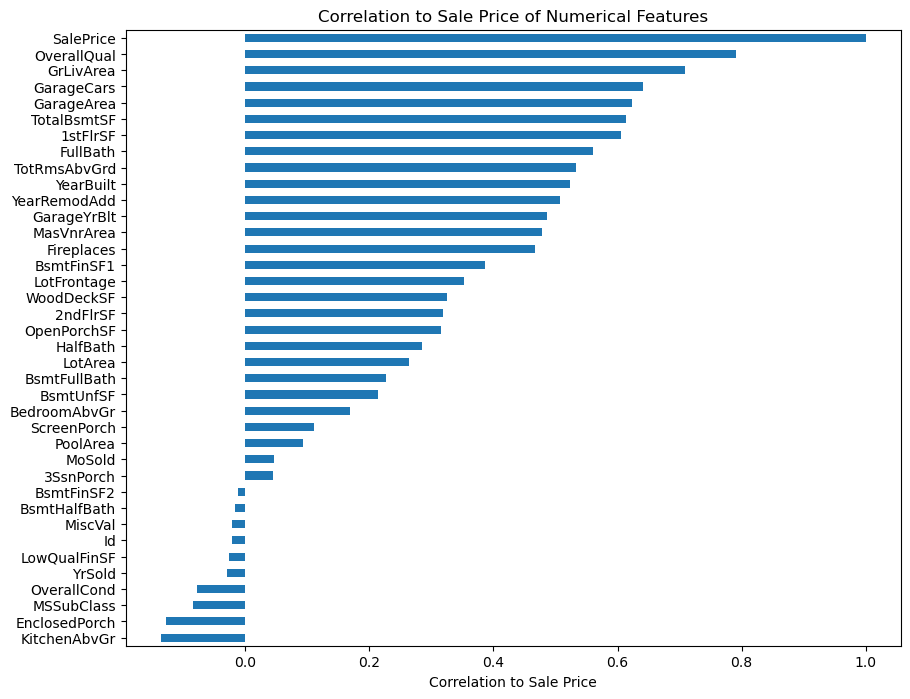

In [5]:
corr_vector = train_origin_df.select_dtypes(include='number').corr()['SalePrice'].sort_values()
corr_vector.drop('SalePrice', axis=0)
plt.figure(figsize=(10, 8))
corr_vector.plot(kind='barh')

plt.title('Correlation to Sale Price of Numerical Features');
plt.xlabel("Correlation to Sale Price");

Graph insights:
- The number of kitchens above ground has the most negative correlation to the house price.
- "BsmtFinSF2" has little to no correlation to the price.
- "OverallQual" has the highest positive correlation, while "OverallCond" has somewhat negative correlation, meaning physical condition matters less than subjective measures.
- The top 5 features correlated to price mean that people value quality, area of living and garage space. 

#### Categorical Features

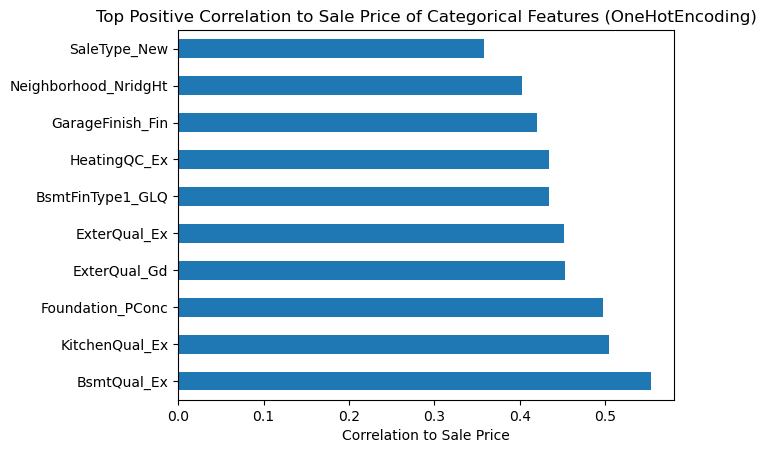

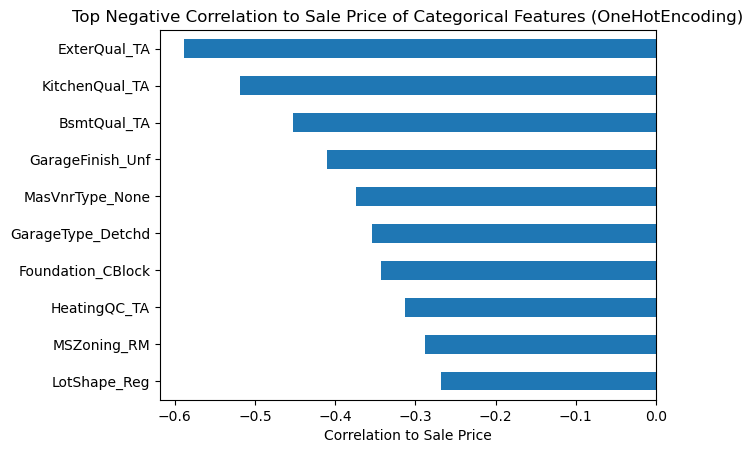

In [6]:
# Checking correlation of target with categorical features (after One-Hot_rncoding) 
import pandas as pd
categorical_columns = train_origin_df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(train_origin_df, columns=categorical_columns)
correlation = df_encoded.corr()
categorical_correlation = correlation['SalePrice'].drop(train_origin_df.select_dtypes(include=[np.number]).columns)
sorted_correlation = categorical_correlation.sort_values(ascending=False)

sorted_correlation.head(10).plot(kind='barh')
plt.title('Top Positive Correlation to Sale Price of Categorical Features (OneHotEncoding)');
plt.xlabel("Correlation to Sale Price");
plt.show() 

sorted_correlation.tail(10).plot(kind='barh')
plt.title('Top Negative Correlation to Sale Price of Categorical Features (OneHotEncoding)');
plt.xlabel("Correlation to Sale Price");
plt.show() 

### 1.5 More EDA that will help us understand the data and support our modelling decisions

In [7]:
# todo - what will be our modeling decision?
# todo - what graphs will support this?

#### Feature selection (searching features that can be dropped)
The idea is that due to the large number of features in the original dataset (80, not including the target), it might be beneficial to reduce the number of features. We do this in differnet ways:

##### Highly correlated numerical features
We looked for highly correlated features and decided to drop one of each pair:

In [8]:
categorical_columns = train_features.describe(include=[object]).T.index
numeric_columns = train_features.describe(include=[np.number]).T.index

num_corr = train_features[numeric_columns].corr()
correlation_matrix = train_features[numeric_columns].corr()
threshold = 0.7
highly_correlated_numeric_features = []

for i in range(len(numeric_columns)):
  for j in range(i+1, len(numeric_columns)):
    feature1 = numeric_columns[i]
    feature2 = numeric_columns[j]
    correlation = correlation_matrix.iloc[i,j]

    if correlation > threshold:
      highly_correlated_numeric_features.append((feature1, feature2, round(correlation, 3)))

print(highly_correlated_numeric_features)

[('YearBuilt', 'GarageYrBlt', 0.826), ('TotalBsmtSF', '1stFlrSF', 0.82), ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('GarageCars', 'GarageArea', 0.882)]


In [9]:
#features to drop due to high correlation with another feature (one from each pair):
# we drop features that are not common to all samples (e.g., all buildings must have YearBuilt but not necessarily GarageYrBlt)
high_correlated_features_to_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']

##### Correlation of categorical object type features with the target
By plotting the categorical distributions of each (categorical) feature with respect to the target, we can choose specific features that seem to hold few meaningful information (mostly features with approximately uniform distribution or highly imbalanced distribtion).

In [10]:
# Object features that show low correlation to target (by indirect impresion):
cat_cols_uncor_w_target = ['LotShape', 'LandContour', 'LotConfig',
                           'LandSlope', 'Condition2', 'RoofMatl', 'BsmtExposure',
                           'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                           'Functional', 'Fence', 'MiscFeature'
                           ]

##### Numerical features with imbalanced data

In [11]:
#numerical features to drop due to high imbalance of the data:
drop_imbalanced = ['Heating', 'Alley', 'Street', 'Utilities']


In [12]:
# features with NaN values that relflect 'None' and should not be discraded (should be counted):
convert_nan_to_str = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageType',
                      'GarageFinish', 'GarageQual', 'GarageCond'
                      ]

# features with same problem, but were already dropped due to other reasons:
#['BsmtExposure', 'BsmtFinType1', 'PoolQC', 'MiscFeature]

In [13]:
# filtering the data frame according to selected features to drop:
filtered_df = train_origin_df.drop(high_correlated_features_to_drop, axis=1)
filtered_df = filtered_df.drop(cat_cols_uncor_w_target, axis=1)
filtered_df.drop(drop_imbalanced, axis=1, inplace=True)

for feature in convert_nan_to_str:
  filtered_df[feature].fillna(value='No', inplace=True)

##### Feature engineering on pool information

In [14]:
# only 7 samples with pool, but might be important, so:
# we create new *binary* feature 'HavePool' and drop 'PoolQC' 'PoolArea'

filtered_df['HavePool'] = filtered_df['PoolArea']
filtered_df.loc[filtered_df['HavePool'] != 0, 'HavePool'] = 1
filtered_df.loc[filtered_df['HavePool'] == 0, 'HavePool'] = 0
filtered_df.drop(['PoolArea', 'PoolQC'], axis=1, inplace=True)

##### Treating missing values

In [15]:
# replacing missing values in 'LotFrontage' with mean values:
mean_value_LotFrontage = filtered_df['LotFrontage'].mean()
filtered_df['LotFrontage'].fillna(value=mean_value_LotFrontage, inplace=True)

#### Understanding The Data

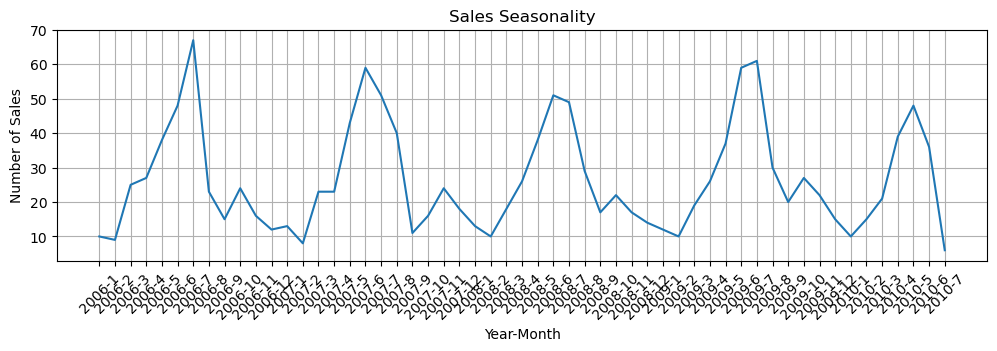

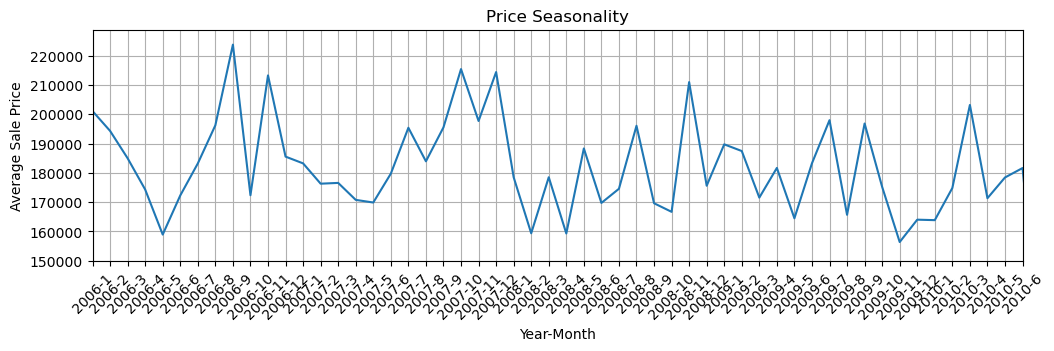

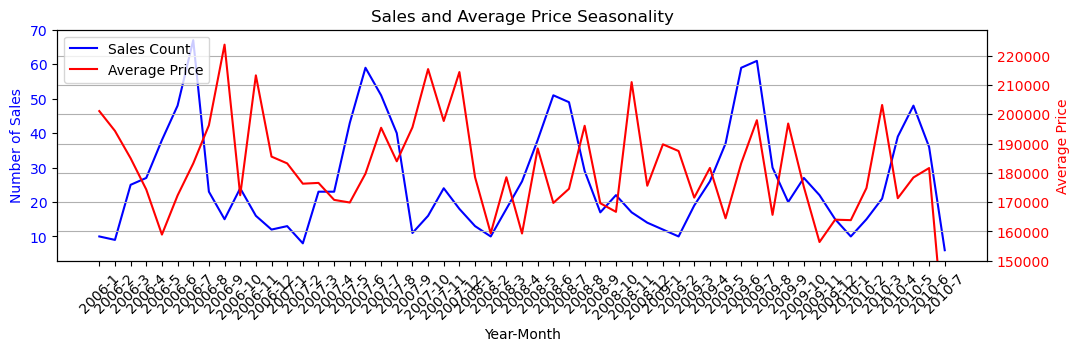

In [16]:
# Looking for seasonality in number of sales 
sales_grouped = filtered_df.groupby(['YrSold', 'MoSold']).size()
sales_grouped_reset = sales_grouped.reset_index(name='Count')
sales_grouped_reset['Year-Month'] = sales_grouped_reset['YrSold'].astype(str) + '-' + sales_grouped_reset['MoSold'].astype(str)
plt.figure(figsize=(12, 3))
plt.plot(sales_grouped_reset['Year-Month'], sales_grouped_reset['Count'])
plt.xticks(rotation=45)
plt.title('Sales Seasonality')
plt.xlabel('Year-Month')
plt.ylabel('Number of Sales')
plt.grid(True)

#looking for seasonality in sale prices 
price_grouped = filtered_df.groupby(['YrSold', 'MoSold'])['SalePrice'].mean()
price_grouped_reset = price_grouped.reset_index(name='AvgPrice')
price_grouped_reset['Year-Month'] = price_grouped_reset['YrSold'].astype(str) + '-' + price_grouped_reset['MoSold'].astype(str)
plt.figure(figsize=(12, 3))
plt.plot(price_grouped_reset['Year-Month'], price_grouped_reset['AvgPrice'])
plt.xticks(rotation=45)
plt.title('Price Seasonality')
plt.xlabel('Year-Month')
plt.ylabel('Average Sale Price')
plt.xlim('2006-1', '2010-6')
plt.ylim(150000)
plt.grid(True)

# Looking for correlation in both seasonality patterns 
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(sales_grouped_reset['Year-Month'], sales_grouped_reset['Count'], label='Sales Count', color='blue')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Number of Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(price_grouped_reset['Year-Month'], price_grouped_reset['AvgPrice'], label='Average Price', color='red')
ax2.set_ylabel('Average Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.set_ylim(150000)
plt.title('Sales and Average Price Seasonality')
plt.grid(True)
plt.show()

The plots above demonstrate pretty clear seasonality in two features: 
* Sales seasonality: we can see a peak in the number of sales on a yearly basis around May-June, followed by a decrease in sales from June to January, with mainly January as the weakest month. 
* Price seasonality: We can see some seasonality in sales prices, albeit less consistent than in the number of sales case. 

Instrestingly, by looking at the combined plot we can see some periods where the number of sales drops down drastically while average price hits a peak. 

## Part 2 - Baseline Model

In [17]:
# todo train the simplest baseline model possible
# todo share baseline model results
# todo submit your baseline results to kaggle website

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [51]:
train_for_model = train_origin_df.copy()

display(train_for_model.isna().sum().sum())
print(train_for_model.columns)

pipe = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
        ("num_imputer", SimpleImputer(missing_values=pd.NA, strategy='mean'),
         make_column_selector(dtype_include='number')),
        ("category_imputer", SimpleImputer(missing_values=pd.NA, strategy='constant', fill_value='None'),
         make_column_selector(dtype_include='object'))
        ],
        verbose_feature_names_out=False).set_output(transform='pandas')
    )
])

train_for_model_imputed_wrong_column_order = pipe.fit_transform(train_for_model)
train_for_model = train_for_model_imputed_wrong_column_order[train_for_model.columns]

display(train_for_model.isna().sum().sum())
print(train_for_model.columns)

categorical_columns = train_for_model.select_dtypes(include='object').columns
train_for_model = pd.get_dummies(train_for_model, columns=categorical_columns, drop_first=True)

train, validation = train_test_split(train_for_model, test_size=0.2, random_state=0)



simple_linear_model.fit(train.drop('SalePrice', axis = 1), train['SalePrice'])
y_pred = simple_linear_model.predict(validation.drop('SalePrice', axis = 1))
y_true = np.array(validation['SalePrice'])
# # print(y_pred < 0)
# # print(y_true < 0)

rmse = mean_squared_error(y_true, y_pred)
print(np.sqrt(rmse))

6965

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

0

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive